In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate,Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import keras

model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu',padding='valid', input_shape=(224, 224, 3),name='Conv2D_1'))
model.add(BatchNormalization(name='BN_1'))
model.add(MaxPooling2D(2, 2,name='MaxPool2D_1'),)

model.add(Conv2D(64, (3, 3),padding='valid', activation='relu',name='Conv2D_2'))
model.add(BatchNormalization(name='BN_2'))
model.add(MaxPooling2D(2, 2,name='MaxPool2D_2'),)

model.add(Conv2D(256, (3, 3),padding='valid', activation='relu',name='Conv2D_3'))
model.add(BatchNormalization(name='BN_3'))
model.add(MaxPooling2D(2, 2,name='MaxPool2D_3'),)

model.add(Conv2D(384, (3, 3),padding='valid', activation='relu',name='Conv2D_4'))
model.add(BatchNormalization(name='BN_4'))
model.add(Conv2D(256, (3, 3),padding='valid', activation='relu',name='Conv2D_5'))
model.add(BatchNormalization(name='BN_5'))
model.add(MaxPooling2D(2, 2,name='MaxPool2D_4'),)

model.add(Conv2D(64, (3, 3),padding='valid', activation='relu',name='Conv2D_6'))
model.add(BatchNormalization(name='BN_6'))
model.add(MaxPooling2D(2, 2,name='MaxPool2D_5'),)

model.add(Conv2D(16, (3, 3),padding='valid', activation='relu',name='Conv2D_7'))
model.add(BatchNormalization(name='BN_7'))
model.add(MaxPooling2D(2, 2,name='MaxPool2D_6'),)


model.add(Flatten(name='Flatten_1'))
model.add(Dense(128, activation='relu',name='Dense_1'))
model.add(Dense(64, activation='relu',name='Dense_2'))
model.add(Dense(5, activation='softmax',name='Dense_3'))  # Assuming 5 classes
model.summary()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_checkpoint_callback = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=30,restore_best_weights=True)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 BN_1 (BatchNormalization)   (None, 222, 222, 16)      64        
                                                                 
 MaxPool2D_1 (MaxPooling2D)  (None, 111, 111, 16)      0         
                                                                 
 Conv2D_2 (Conv2D)           (None, 109, 109, 64)      9280      
                                                                 
 BN_2 (BatchNormalization)   (None, 109, 109, 64)      256       
                                                                 
 MaxPool2D_2 (MaxPooling2D)  (None, 54, 54, 64)        0         
                                                                 
 Conv2D_3 (Conv2D)           (None, 52, 52, 256)      

In [ ]:
from keras.models import Model
from keras.layers import Input, Activation, Concatenate
from keras.layers import Dropout
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras import regularizers
import keras
def fire_module(input_fire, s1, e1, e3, weight_decay_l2, fireID):
    '''
    A wrapper to build fire module

    # Arguments
        input_fire: input activations
        s1: number of filters for squeeze step
        e1: number of filters for 1x1 expansion step
        e3: number of filters for 3x3 expansion step
        weight_decay_l2: weight decay for conv layers
        fireID: ID for the module

    # Return
        Output activations
    '''

    # Squezee step
    output_squeeze = Convolution2D(
        s1, (1, 1), activation='relu',
        kernel_initializer='glorot_uniform',
        kernel_regularizer=regularizers.l2(weight_decay_l2),
        padding='same', name='fire' + str(fireID) + '_squeeze',
        data_format="channels_last")(input_fire)
    # Expansion steps
    output_expand1 = Convolution2D(
        e1, (1, 1), activation='relu',
        kernel_initializer='glorot_uniform',
        kernel_regularizer=regularizers.l2(weight_decay_l2),
        padding='same', name='fire' + str(fireID) + '_expand1',
        data_format="channels_last")(output_squeeze)
    output_expand2 = Convolution2D(
        e3, (3, 3), activation='relu',
        kernel_initializer='glorot_uniform',
        kernel_regularizer=regularizers.l2(weight_decay_l2),
        padding='same', name='fire' + str(fireID) + '_expand2',
        data_format="channels_last")(output_squeeze)
    # Merge expanded activations
    output_fire = Concatenate(axis=3)([output_expand1, output_expand2])
    return output_fire

def SqueezeNet(num_classes, weight_decay_l2=0.0001, inputs=(224, 224, 3)):
    '''
    A wrapper to build SqueezeNet Model

    # Arguments
        num_classes: number of classes defined for classification task
        weight_decay_l2: weight decay for conv layers
        inputs: input image dimensions

    # Return
        A SqueezeNet Keras Model
    '''
    input_img = Input(shape=inputs)

    conv1 = Convolution2D(
        32, (7, 7), activation='relu', kernel_initializer='glorot_uniform',
        strides=(2, 2), padding='same', name='conv1',
        data_format="channels_last")(input_img)

    maxpool1 = MaxPooling2D(
        pool_size=(2, 2), strides=(2, 2), name='maxpool1',
        data_format="channels_last")(conv1)

    fire2 = fire_module(maxpool1, 8, 16, 16, weight_decay_l2, 2)
    fire3 = fire_module(fire2, 8, 16, 16, weight_decay_l2, 3)
    fire4 = fire_module(fire3, 16, 32, 32, weight_decay_l2, 4)

    maxpool4 = MaxPooling2D(
        pool_size=(2, 2), strides=(2, 2), name='maxpool4',
        data_format="channels_last")(fire4)

    fire5 = fire_module(maxpool4, 16, 32, 32, weight_decay_l2, 5)
    fire6 = fire_module(fire5, 32, 64, 64, weight_decay_l2, 6)
    fire7 = fire_module(fire6, 32, 64, 64, weight_decay_l2, 7)
    fire8 = fire_module(fire7, 64, 128, 128, weight_decay_l2, 8)

    maxpool8 = MaxPooling2D(
        pool_size=(2, 2), strides=(2, 2), name='maxpool8',
        data_format="channels_last")(fire8)

    fire9 = fire_module(maxpool8, 64, 128, 128, weight_decay_l2, 9)

    conv10 = Convolution2D(
        num_classes, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='valid', name='conv10',
        data_format="channels_last")(fire9)

    global_avgpool10 = GlobalAveragePooling2D(data_format='channels_last')(conv10)
    softmax = Activation("softmax", name='softmax')(global_avgpool10)

    return Model(inputs=input_img, outputs=softmax)


model = SqueezeNet(5)
model.summary()

opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_checkpoint_callback = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=30,restore_best_weights=True)

history = model.fit(train_images, train_lables, batch_size=8, epochs=250,

validation_data=(valid_images, valid_lables), callbacks=[model_checkpoint_callback])
test_loss=model.evaluate(test_images,test_lables)
predictions=model.predict(test_images)
pred_lables=np.argmax(predictions,axis=1)
print(classification_report(test_lables,pred_lables))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 32)         4736      ['input_1[0][0]']             
                                                                                                  
 maxpool1 (MaxPooling2D)     (None, 56, 56, 32)           0         ['conv1[0][0]']               
                                                                                                  
 fire2_squeeze (Conv2D)      (None, 56, 56, 8)            264       ['maxpool1[0][0]']            
                                                                                              

171317808/171317808 [==============================] - 9s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                           

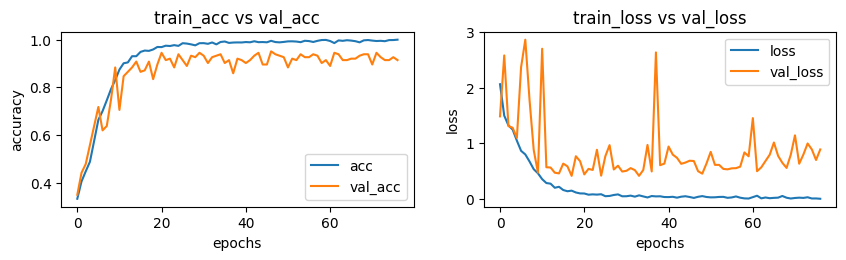

In [ ]:
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate,Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(224, 224, 3))

base_model = ResNet101V2(input_tensor=input_tensor, weights='imagenet',
                    include_top=False )

x = base_model.output
x=Flatten()(x)
x=Dense(128,activation='relu')(x)
x=Dense(64,activation='relu')(x)
x= Dense(5, activation='softmax')(x)

model= Model(inputs=input_tensor, outputs=x)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
for layer in model.layers:
   layer.trainable = True
model.summary()

model_checkpoint_callback = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=30,restore_best_weights=True)

history = model.fit(train_images, train_lables, batch_size=8, epochs=250,

        validation_data=(valid_images, valid_lables), callbacks=[model_checkpoint_callback])
#callbacks = [EarlyStopping(monitor='loss', patience=5)]

test_loss=model.evaluate(test_images,test_lables)
predictions=model.predict(test_images)
pred_lables=np.argmax(predictions,axis=1)
print(classification_report(test_lables,pred_lables))

def plot_accuracy_loss(history):
  fig=plt.figure(figsize=(10,5))

  #plot accuarcy
  plt.subplot(221)
  plt.plot(history.history['accuracy'],label='acc')
  plt.plot(history.history['val_accuracy'],label='val_acc')
  plt.title('train_acc vs val_acc')
  plt.ylabel("accuracy")
  plt.xlabel("epochs")
  plt.legend()


  #plot loss
  plt.subplot(222)
  plt.plot(history.history['loss'],label='loss')
  plt.plot(history.history['val_loss'],label='val_loss')
  plt.title('train_loss vs val_loss')
  plt.ylabel("loss")
  plt.xlabel("epochs")
  plt.legend()

  plt.show()

plot_accuracy_loss(history)

Epoch 1/250
491/491 [==============================] - 46s 49ms/step - loss: 0.4273 - accuracy: 0.8535 - val_loss: 1.0167 - val_accuracy: 0.7423
Epoch 2/250
491/491 [==============================] - 23s 47ms/step - loss: 0.1260 - accuracy: 0.9559 - val_loss: 0.0302 - val_accuracy: 0.9939
Epoch 3/250
491/491 [==============================] - 23s 46ms/step - loss: 0.0877 - accuracy: 0.9659 - val_loss: 0.0878 - val_accuracy: 0.9755
Epoch 4/250
491/491 [==============================] - 23s 46ms/step - loss: 0.0633 - accuracy: 0.9788 - val_loss: 0.0499 - val_accuracy: 0.9816
Epoch 5/250
491/491 [==============================] - 23s 47ms/step - loss: 0.0731 - accuracy: 0.9758 - val_loss: 0.0558 - val_accuracy: 0.9816
Epoch 6/250
491/491 [==============================] - 22s 46ms/step - loss: 0.0755 - accuracy: 0.9804 - val_loss: 0.1047 - val_accuracy: 0.9755
Epoch 7/250
491/491 [==============================] - 22s 46ms/step - loss: 0.0367 - accuracy: 0.9870 - val_loss: 0.1089 - val_ac

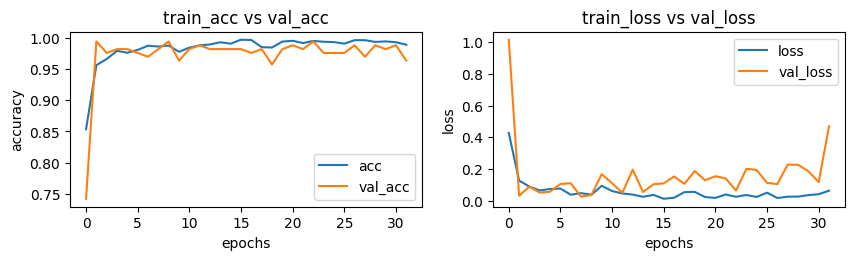

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate,Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(224, 224, 3))

base_model = MobileNetV2(input_tensor=input_tensor, weights='imagenet',
                    include_top=False )

x = base_model.output
x=Flatten()(x)
x=Dense(128,activation='relu')(x)
x=Dense(64,activation='relu')(x)
x= Dense(5, activation='softmax')(x)

model= Model(inputs=input_tensor, outputs=x)

opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

for layer in model.layers:
   layer.trainable = True
#model.summary()

model_checkpoint_callback = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=30,restore_best_weights=True)

history = model.fit(train_images, train_lables, batch_size=8, epochs=250,

        validation_data=(valid_images, valid_lables), callbacks=[model_checkpoint_callback])
#callbacks = [EarlyStopping(monitor='loss', patience=5)]


test_loss=model.evaluate(test_images,test_lables)
predictions=model.predict(test_images)
pred_lables=np.argmax(predictions,axis=1)
print(classification_report(test_lables,pred_lables))

def plot_accuracy_loss(history):
  fig=plt.figure(figsize=(10,5))

  #plot accuarcy
  plt.subplot(221)
  plt.plot(history.history['accuracy'],label='acc')
  plt.plot(history.history['val_accuracy'],label='val_acc')
  plt.title('train_acc vs val_acc')
  plt.ylabel("accuracy")
  plt.xlabel("epochs")
  plt.legend()


  #plot loss
  plt.subplot(222)
  plt.plot(history.history['loss'],label='loss')
  plt.plot(history.history['val_loss'],label='val_loss')
  plt.title('train_loss vs val_loss')
  plt.ylabel("loss")
  plt.xlabel("epochs")
  plt.legend()

  plt.show()

plot_accuracy_loss(history)

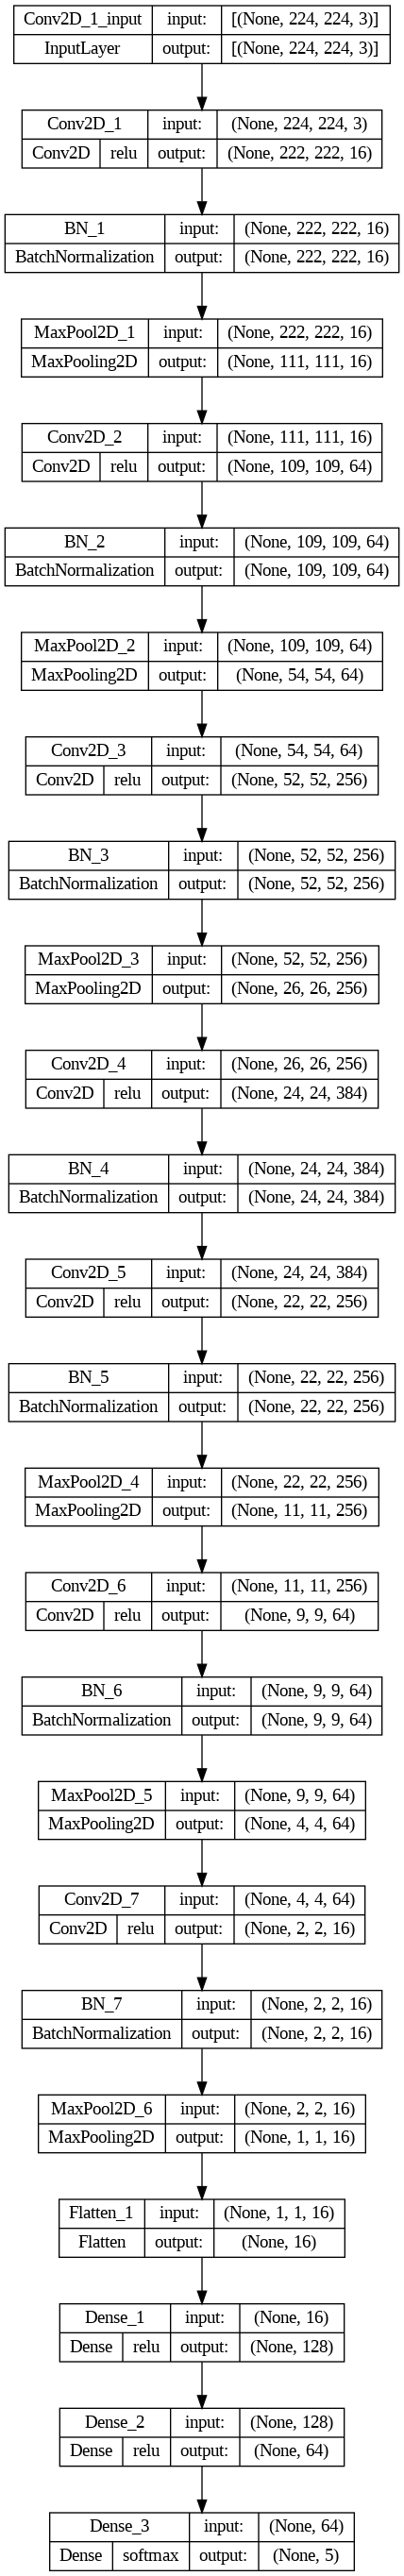

In [ ]:
import keras
keras.utils.plot_model(model, show_shapes=True,show_layer_activations=True)

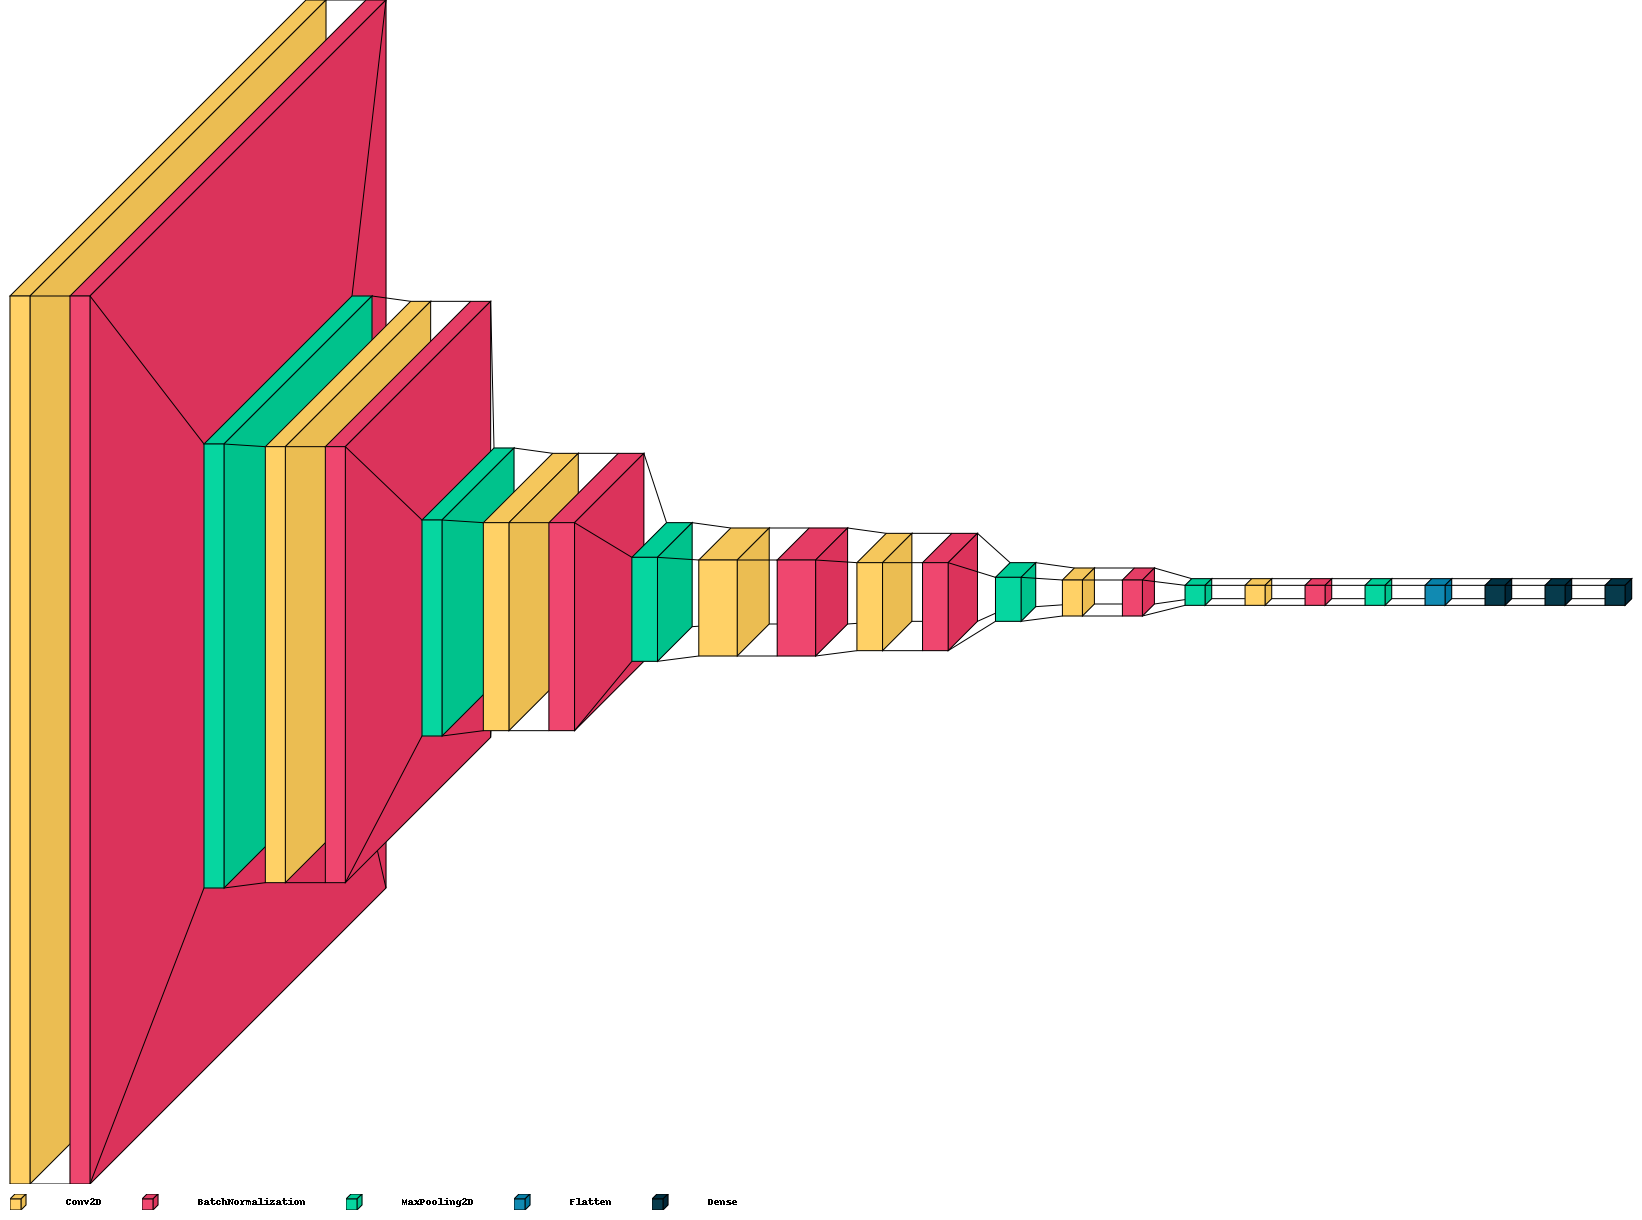

In [ ]:
!pip install visualkeras
import visualkeras

from PIL import ImageFont
visualkeras.layered_view(model)
visualkeras.layered_view(model, legend=True,spacing=40)

In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="okxeUDS7AJdUtbsLvEDO")
project = rf.workspace("atldsd").project("atldsd")
dataset = project.version(1).download("folder")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 769.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninst

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to ATLDSD-1 in folder:: 100%|██████████| 4269/4269 [00:00<00:00, 8594.37it/s]


In [2]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import classification_report
import seaborn as sn
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm

class_names= ['Alternaria leaf spot', 'Brown spot', 'Gray spot', 'Healthy', 'Rust']

class_names_labels={class_name:i for i, class_name in enumerate(class_names)}

print(class_names_labels)

nb_classes=len(class_names)

IMAGE_SIZE=(224,224)

def load_data():
    direct='/content/ATLDSD-1/'
    category=['train','valid','test']

    output=[]

    for cat in category:
      path=os.path.join(direct,cat)
      print(path)

      images=[]
      labels=[]

      for folder in os.listdir(path):
        print("folder:",folder)
        label= class_names_labels[folder]

        #Iterating each image
        for fle in os.listdir(os.path.join(path,folder)):

          img_path=os.path.join(os.path.join(path,folder),fle)

          image=cv2.imread(img_path)
          image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
          image=cv2.resize(image,IMAGE_SIZE)

          images.append(image)
          labels.append(label)

      images=np.array(images,dtype='float32')
      labels=np.array(labels,dtype='int32')

      output.append((images,labels))
    #print(type(output[0]))
    return output

(train_images,train_lables), (valid_images,valid_lables), (test_images,test_lables) = load_data()

{'Alternaria leaf spot': 0, 'Brown spot': 1, 'Gray spot': 2, 'Healthy': 3, 'Rust': 4}
/content/ATLDSD-1/train
folder: Brown spot
folder: Healthy
folder: Gray spot
folder: Rust
folder: Alternaria leaf spot
/content/ATLDSD-1/valid
folder: Brown spot
folder: Healthy
folder: Gray spot
folder: Rust
folder: Alternaria leaf spot
/content/ATLDSD-1/test
folder: Brown spot
folder: Healthy
folder: Gray spot
folder: Rust
folder: Alternaria leaf spot


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 batch_normalization_7 (Bat  (None, 222, 222, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 109, 109, 64)      9280      
                                                                 
 batch_normalization_8 (Bat  (None, 109, 109, 64)      256       
 chNormalization)                                                
                                                      

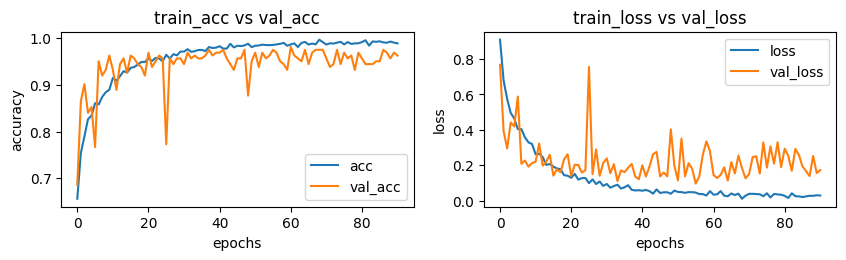

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate,Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import keras

model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu',padding='valid', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3),padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(256, (3, 3),padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(384, (3, 3),padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3),padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3),padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(16, (3, 3),padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))


model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))  # Assuming 5 classes
model.summary()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_checkpoint_callback = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=30,restore_best_weights=True)

history = model.fit(train_images, train_lables, batch_size=8, epochs=250,

        validation_data=(valid_images, valid_lables), callbacks=[model_checkpoint_callback])

test_loss=model.evaluate(test_images,test_lables)
predictions=model.predict(test_images)
pred_lables=np.argmax(predictions,axis=1)
print(classification_report(test_lables,pred_lables))

def plot_accuracy_loss(history):
  fig=plt.figure(figsize=(10,5))

  #plot accuarcy
  plt.subplot(221)
  plt.plot(history.history['accuracy'],label='acc')
  plt.plot(history.history['val_accuracy'],label='val_acc')
  plt.title('train_acc vs val_acc')
  plt.ylabel("accuracy")
  plt.xlabel("epochs")
  plt.legend()


  #plot loss
  plt.subplot(222)
  plt.plot(history.history['loss'],label='loss')
  plt.plot(history.history['val_loss'],label='val_loss')
  plt.title('train_loss vs val_loss')
  plt.ylabel("loss")
  plt.xlabel("epochs")
  plt.legend()

  plt.show()

plot_accuracy_loss(history)

6/6 [==============================] - 0s 28ms/step


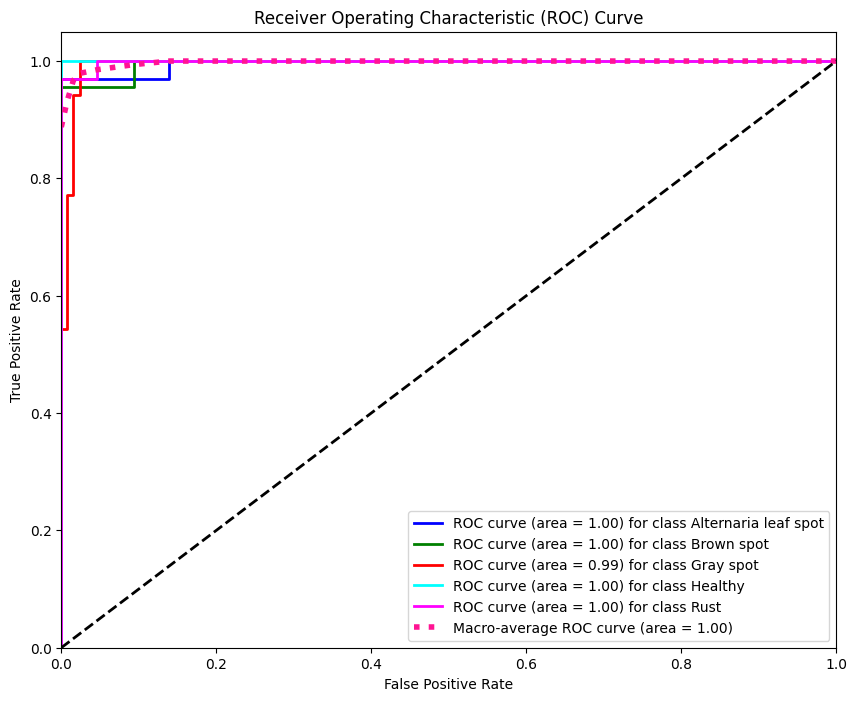

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import load_model

# Assuming you have test data, labels, and predictions
# test_data = ...
# test_labels = ...
# test_predictions = ...

# Number of classes
num_classes = 5

# Map class names to their corresponding numbers
class_mapping = {
'Alternaria leaf spot': 0, 'Brown spot': 1, 'Gray spot': 2, 'Healthy': 3, 'Rust': 4
}

# Reverse the mapping to get class names from numbers
class_names = {v: k for k, v in class_mapping.items()}

# Binarize the labels
y_test = label_binarize(test_lables, classes=range(num_classes))

# Load your Keras model
# model = load_model('your_model_path')

# Predict probabilities
y_score = model.predict(test_images)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Interpolate ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))

# Plot individual ROC curves
colors = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'orange'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], class_names[i]))

# Plot macro-average ROC curve
plt.plot(fpr["macro"], tpr["macro"], color='deeppink', linestyle=':', linewidth=4, label='Macro-average ROC curve (area = {:.2f})'.format(roc_auc["macro"]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


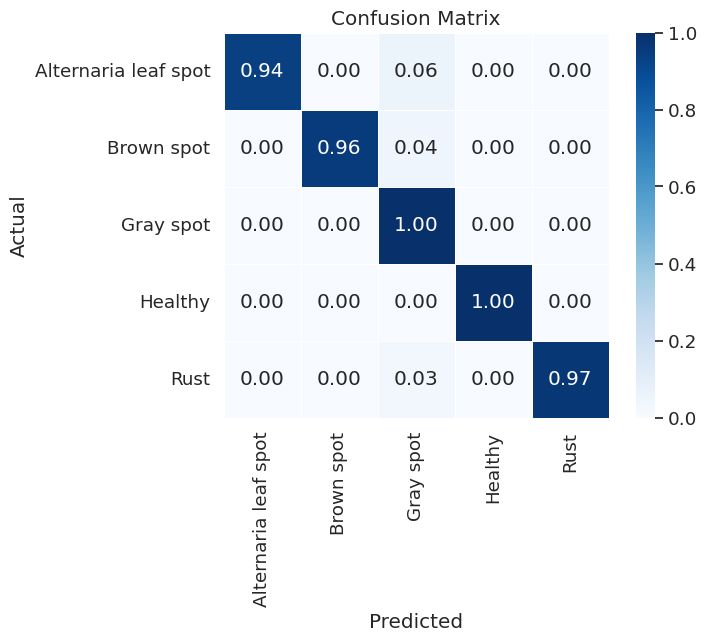

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize

    plt.figure(figsize=(len(class_names) + 2, len(class_names)))
    sns.set(font_scale=1.2)
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", linewidths=.5, square=True,
                xticklabels=class_names, yticklabels=class_names)

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')

    plt.show()

# Example usage:
# Replace y_true and y_pred with your actual and predicted labels
# Replace class_names with your class names
y_true = test_lables  # Replace with your actual labels
y_pred = pred_lables  # Replace with your predicted labels
class_names= class_names= ['Alternaria leaf spot', 'Brown spot', 'Gray spot', 'Healthy', 'Rust']

plot_confusion_matrix(y_true, y_pred, class_names)


In [ ]:
import keras
model.save_weights('/content/atldsd_custom.h5', overwrite=True)

Epoch 1/250
491/491 [==============================] - 88s 100ms/step - loss: 1.5287 - accuracy: 0.5586 - val_loss: 0.5592 - val_accuracy: 0.8098
Epoch 2/250
491/491 [==============================] - 41s 84ms/step - loss: 0.7678 - accuracy: 0.7258 - val_loss: 33.7004 - val_accuracy: 0.4969
Epoch 3/250
491/491 [==============================] - 41s 84ms/step - loss: 0.6700 - accuracy: 0.7582 - val_loss: 0.5751 - val_accuracy: 0.7914
Epoch 4/250
491/491 [==============================] - 41s 84ms/step - loss: 0.6092 - accuracy: 0.7900 - val_loss: 1.3251 - val_accuracy: 0.6442
Epoch 5/250
491/491 [==============================] - 41s 84ms/step - loss: 0.5416 - accuracy: 0.8132 - val_loss: 2.7168 - val_accuracy: 0.6319
Epoch 6/250
491/491 [==============================] - 41s 84ms/step - loss: 0.5502 - accuracy: 0.8119 - val_loss: 2.1479 - val_accuracy: 0.7178
Epoch 7/250
491/491 [==============================] - 41s 84ms/step - loss: 0.4861 - accuracy: 0.8285 - val_loss: 1.3854 - val_

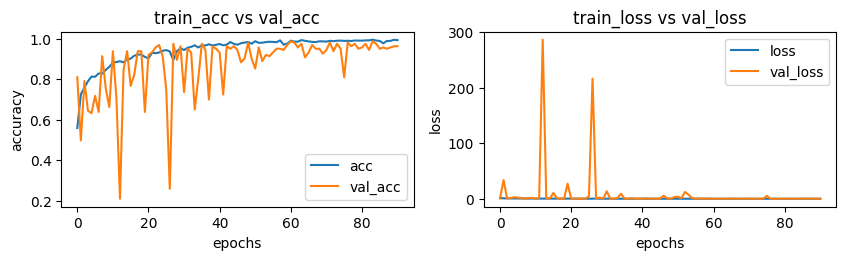

In [ ]:


from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate,Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(224, 224, 3))

base_model = InceptionV3(input_tensor=input_tensor, weights=None,
                    include_top=False )
base_model.trainable = True
x = base_model.output
x=Flatten()(x)
x=Dense(128,activation='relu')(x)
x=Dense(64,activation='relu')(x)
x= Dense(5, activation='softmax')(x)

model= Model(inputs=input_tensor, outputs=x)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
"""for layer in model.layers:
   layer.trainable = True"""
#model.summary()

model_checkpoint_callback = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=30,restore_best_weights=True)

history = model.fit(train_images, train_lables, batch_size=8, epochs=250,

        validation_data=(valid_images, valid_lables), callbacks=[model_checkpoint_callback])

#callbacks = [EarlyStopping(monitor='loss', patience=5)]
test_loss=model.evaluate(test_images,test_lables)
predictions=model.predict(test_images)
pred_lables=np.argmax(predictions,axis=1)
print(classification_report(test_lables,pred_lables))

def plot_accuracy_loss(history):
  fig=plt.figure(figsize=(10,5))

  #plot accuarcy
  plt.subplot(221)
  plt.plot(history.history['accuracy'],label='acc')
  plt.plot(history.history['val_accuracy'],label='val_acc')
  plt.title('train_acc vs val_acc')
  plt.ylabel("accuracy")
  plt.xlabel("epochs")
  plt.legend()


  #plot loss
  plt.subplot(222)
  plt.plot(history.history['loss'],label='loss')
  plt.plot(history.history['val_loss'],label='val_loss')
  plt.title('train_loss vs val_loss')
  plt.ylabel("loss")
  plt.xlabel("epochs")
  plt.legend()

  plt.show()

plot_accuracy_loss(history)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 26, 26, 96)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 26, 26, 96)        384       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 256)       0         
 g2D)                                                            
                                                        

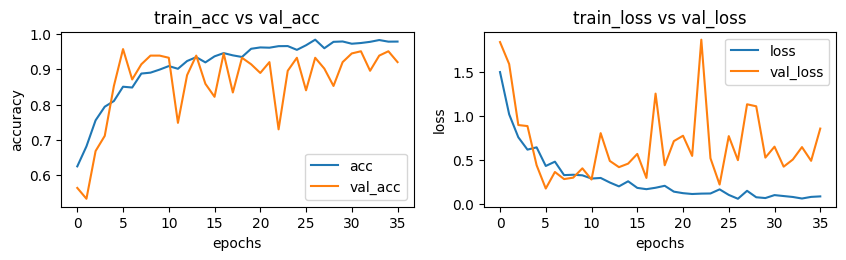

In [ ]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate,Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
# Initializing the CNN
model = Sequential()

model.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                      padding= 'valid', activation= 'relu',
                      input_shape= (224,224,3),
                      kernel_initializer= 'he_normal'))
model.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                      padding= 'valid', data_format= None))
model.add(BatchNormalization())


model.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                padding= 'same', activation= 'relu',
                kernel_initializer= 'he_normal'))
model.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                      padding= 'valid', data_format= None))
model.add(BatchNormalization())


model.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                padding= 'same', activation= 'relu',
                kernel_initializer= 'he_normal'))
model.add(BatchNormalization())


model.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                padding= 'same', activation= 'relu',
                kernel_initializer= 'he_normal'))
model.add(BatchNormalization())


model.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                padding= 'same', activation= 'relu',
                kernel_initializer= 'he_normal'))

model.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                      padding= 'valid', data_format= None))
model.add(BatchNormalization())



# Flattening Step
model.add(Flatten())

# Full Connection Step
model.add(Dense(units = 4096, activation = 'relu'))
model.add(Dense(units = 4096, activation = 'relu'))
model.add(Dense(units = 5, activation = 'softmax'))
model.summary()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_checkpoint_callback = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=30,restore_best_weights=True)

history = model.fit(train_images, train_lables, batch_size=8, epochs=250,

        validation_data=(valid_images, valid_lables), callbacks=[model_checkpoint_callback])


test_loss=model.evaluate(test_images,test_lables)
predictions=model.predict(test_images)
pred_lables=np.argmax(predictions,axis=1)
print(classification_report(test_lables,pred_lables))

def plot_accuracy_loss(history):
  fig=plt.figure(figsize=(10,5))

  #plot accuarcy
  plt.subplot(221)
  plt.plot(history.history['accuracy'],label='acc')
  plt.plot(history.history['val_accuracy'],label='val_acc')
  plt.title('train_acc vs val_acc')
  plt.ylabel("accuracy")
  plt.xlabel("epochs")
  plt.legend()


  #plot loss
  plt.subplot(222)
  plt.plot(history.history['loss'],label='loss')
  plt.plot(history.history['val_loss'],label='val_loss')
  plt.title('train_loss vs val_loss')
  plt.ylabel("loss")
  plt.xlabel("epochs")
  plt.legend()

  plt.show()

plot_accuracy_loss(history)

94668760/94668760 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                             

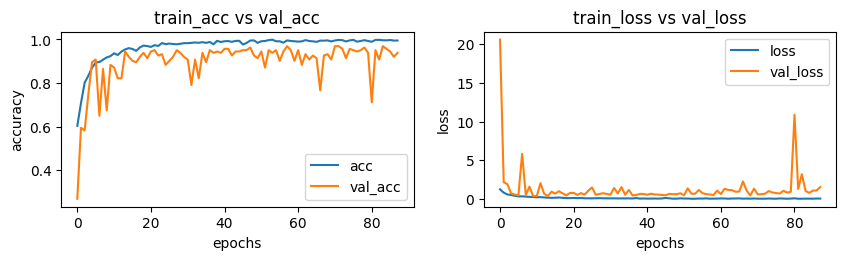

In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate,Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(224, 224, 3))

base_model = ResNet50V2(input_tensor=input_tensor, weights='imagenet',
                    include_top=False )

x = base_model.output
x=Flatten()(x)
x=Dense(128,activation='relu')(x)
x=Dense(64,activation='relu')(x)
x= Dense(5, activation='softmax')(x)

model= Model(inputs=input_tensor, outputs=x)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
for layer in model.layers:
   layer.trainable = True
model.summary()

model_checkpoint_callback = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=30,restore_best_weights=True)

history = model.fit(train_images, train_lables, batch_size=8, epochs=250,

        validation_data=(valid_images, valid_lables), callbacks=[model_checkpoint_callback])
#callbacks = [EarlyStopping(monitor='loss', patience=5)]

test_loss=model.evaluate(test_images,test_lables)
predictions=model.predict(test_images)
pred_lables=np.argmax(predictions,axis=1)
print(classification_report(test_lables,pred_lables))

def plot_accuracy_loss(history):
  fig=plt.figure(figsize=(10,5))

  #plot accuarcy
  plt.subplot(221)
  plt.plot(history.history['accuracy'],label='acc')
  plt.plot(history.history['val_accuracy'],label='val_acc')
  plt.title('train_acc vs val_acc')
  plt.ylabel("accuracy")
  plt.xlabel("epochs")
  plt.legend()


  #plot loss
  plt.subplot(222)
  plt.plot(history.history['loss'],label='loss')
  plt.plot(history.history['val_loss'],label='val_loss')
  plt.title('train_loss vs val_loss')
  plt.ylabel("loss")
  plt.xlabel("epochs")
  plt.legend()

  plt.show()

plot_accuracy_loss(history)